In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.contrib import rnn
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sklearn
print tf.__version__
print sklearn.__version__

1.0.1
0.18.1


In [32]:
collapsed_shifted = pd.read_csv('data/collapsed_shifted.csv', header = 0)
collapsed_shifted.reset_index(drop = True,inplace = True)
security_return = pd.read_csv('data/security_return.csv',header = 0)
security_return.reset_index(drop = True,inplace = True)

In [33]:
collapsed_shifted = collapsed_shifted.merge(security_return,on = 'Date')
collapsed_shifted.set_index('Date',inplace = True)
security_return.set_index('Date',inplace = True)

In [34]:
collapsed_shifted.head(5)

,GoldsteinScale,NumMentions,avgtone,numarticles,numsources,wit_co,unemploy,m1v,m2v,slsi,vix,dff,Adj Close
Date,,,,,,,,,,,,,
2000-07-03,1.190281,-1.697420,-2.254986,-1.705705,4.699044,1.206156,0.772398,1.616579,-0.578440,0.634732,-1.536171,2.205601,14.940063
2000-07-05,0.014689,1.626916,0.231821,1.911170,-0.639102,1.181671,0.805202,1.568076,-0.602027,0.611325,-1.396736,2.565825,-23.310059
2000-07-06,-0.318263,0.325537,-0.284617,0.496834,-0.629554,0.558270,0.803556,1.545339,-0.614243,0.599685,-0.963737,0.991704,10.440064
2000-07-07,-1.154252,1.191088,-0.469272,0.542449,0.582770,0.349708,0.801914,1.523565,-0.626760,0.588081,-1.034268,0.946276,22.229980
2000-07-10,-0.332103,-0.134304,1.287144,-0.004239,0.322320,0.389241,0.797012,1.463757,-0.666289,-0.063670,-1.590751,0.632653,-3.280029


In [35]:
'''Important features selected by DeepLIFT and Integrated Gradients methods from Michael and Yaqing 
   Pick the top 50% of the most important features 
'''
#input_features = ['wit_co','unemploy','m1v','slsi','vix','dff','avgtone','m2v', 'Adj Close']
input_features = ['vix','slsi','unemploy','wit_co', 'm1v', 'm2v', 'dff']
collapsed_shifted = collapsed_shifted[input_features]

In [36]:
collapsed_shifted.head(5)

,vix,slsi,unemploy,wit_co,m1v,m2v,dff
Date,,,,,,,
2000-07-03,-1.536171,0.634732,0.772398,1.206156,1.616579,-0.578440,2.205601
2000-07-05,-1.396736,0.611325,0.805202,1.181671,1.568076,-0.602027,2.565825
2000-07-06,-0.963737,0.599685,0.803556,0.558270,1.545339,-0.614243,0.991704
2000-07-07,-1.034268,0.588081,0.801914,0.349708,1.523565,-0.626760,0.946276
2000-07-10,-1.590751,-0.063670,0.797012,0.389241,1.463757,-0.666289,0.632653


In [37]:
print ('Creating train test split...')
test_size = 0.15
print ('Train Test split without shuffling percentage %.2f' % test_size)
X_train = collapsed_shifted.iloc[:int(len(collapsed_shifted)*(1-test_size))]
X_test = collapsed_shifted.iloc[int(len(collapsed_shifted)*(1-test_size)):]
Y_train = security_return.iloc[:int(len(collapsed_shifted)*(1-test_size))]
Y_test = security_return.iloc[int(len(collapsed_shifted)*(1-test_size)):]
y_date = Y_test.index
# X_train,X_test,Y_train,Y_test = train_test_split(collapsed_shifted,security_return,stratify=None,test_size=.10)
#X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=.20,stratify=None,shuffle=False)

#Creating Copies of Data Frames these will be useful later for debugging
X_train_df = X_train.copy(True)
Y_train_df = Y_train.copy(True)
X_train  = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Creating train test split...
Train Test split without shuffling percentage 0.15


In [24]:
print 'training data in total %i' % len(X_train)
print 'testing data in total %i' % len(X_test)

training data in total 3692
testing data in total 652


In [10]:
class Batch(object):
    def __init__(self, inputs, labels, batch_size = 16, seq_lens = 7, shuffle = False):
        self.inputs = inputs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.seq_lens = seq_lens
        
    def get_batch(self, step):
        '''process one batch for training
        Args:
            X: 1->T Y:1->T-1 label: T
        '''
        
        X = [np.expand_dims(self.inputs[step+i:step+self.seq_lens+i],0) for i in range(self.batch_size)]
        X_batch = np.concatenate(X,axis = 0)
        Y = [np.expand_dims(self.labels[step+i:step+self.seq_lens+i],0) for i in range(self.batch_size)]
        Y_batch = np.squeeze(np.concatenate(Y,axis = 0))
        labels = np.array([self.labels[step+self.seq_lens+i] for i in range(self.batch_size)]).reshape(-1,1)
        
        if self.shuffle:
            index = range(self.batch_size)
            np.random.shuffle(index)
            X_batch = X_batch[index]
            y_batch = Y_batch[index]
            labels = labels[index]
        return X_batch, Y_batch, labels

In [40]:
class ts_prediction(object):
    ''' add dropout to last hidden state for training, dropout_keep_prob'''
    def __init__(self, input_dim, time_step, n_hidden, d_hidden, batch_size, is_train = True, dropout_keep_prob = 0.5, max_grad_norm = 5.0, add_highway = False):

        self.batch_size = batch_size
        self.n_hidden = n_hidden
        self.d_hidden = d_hidden
        self.is_train = is_train # for dropout
        self.input_dim = input_dim
        self.time_step = time_step
        self.seq_len = tf.placeholder(tf.int32,[None])
        self.input_x = tf.placeholder(dtype = tf.float32, shape = [None, self.time_step, input_dim]) # b,T,d_in
        self.input_y = tf.placeholder(dtype = tf.float32,shape = [None,self.time_step]) # b,T
        self.label = tf.placeholder(dtype = tf.float32, shape = [None,1]) #b,1
        self.original_loss = tf.placeholder(dtype = tf.float32, shape = [])
        self.dropout_keep_prob = dropout_keep_prob
        self.max_grad_norm = max_grad_norm
        ## placeholder for loss without adversarial gradient added
        
        self.encode_cell = tf.contrib.rnn.LSTMCell(self.n_hidden, forget_bias=1.0, state_is_tuple=True)
        self.decode_cell = tf.contrib.rnn.LSTMCell(self.d_hidden, forget_bias=1.0, state_is_tuple=True)
        
        self.loss_1 = tf.constant(0.0)
        self.loss = tf.constant(0.0)
        self.rand_unif_init = tf.random_uniform_initializer(-0.1, 0.1)
            ## ===========  build the model =========== ##
        self.global_step = tf.Variable(0,dtype = tf.int32, name = 'global_step', trainable = False)
            ## ==== encoder ===== ## 
        h_encode, c_state = self._add_encoder(self.input_x, scopes = 'fw_lstm')

        attn_dists = self._attention_encoder(h_encode, c_state, self.input_x) # b,T,D
        self._attn_dists = tf.nn.softmax(tf.reduce_sum(attn_dists,axis = 1)) # b,D for visualization purpose
        
        encoded_input = tf.multiply(self.input_x,attn_dists)
        encoded_input.set_shape([None,self.time_step,input_dim])
        
        h_t, c_t = self._add_encoder(encoded_input, scopes = 'fw_lstm')
        
        weighted_sum = self._attention_decoder(h_t) # b,d_hidden
        
        if self.is_train:
            dropout_sum = tf.nn.dropout(weighted_sum, keep_prob = self.dropout_keep_prob)
        else:
            dropout_keep_prob = 1
            dropout_sum = tf.nn.dropout(weighted_sum, keep_prob = self.dropout_keep_prob)
        
        if add_highway:
            sizes = [32, 32]
            dropout_sum = self._highway(dropout_sum, sizes, f=tf.nn.relu, scope='Highway')
        # add dense layer before prediction
        self.y_predict = tf.layers.dense(dropout_sum, units = 1, use_bias = True, name = 'y_predict') # b, 1
        
        self._loss = tf.reduce_mean(tf.square(self.label - self.y_predict)) # avg over batch
        if self.is_train:
            self._add_train_op()
          
    def _add_encoder(self, input_x, scopes = 'fw_lstm'):
        '''
        input_x: b, T, d_in
        
        output: h:       seqence of output state b,T,n_hidden
                state:   final state b,n_hidden
                
        '''
        with tf.variable_scope('fw_lstm' or scopes) as scope:
            try:
                h,state = tf.nn.dynamic_rnn(cell = self.encode_cell, inputs = input_x,
                                            sequence_length = self.seq_len, dtype = tf.float32, scope = 'fw_lstm')
            except ValueError:
                scope.reuse_variables()
                h,state = tf.nn.dynamic_rnn(cell = self.encode_cell, inputs = input_x, 
                                            sequence_length = self.seq_len, dtype = tf.float32, scope = scopes)
        
        return [h,state]
    
    def _attention_encoder(self, enc_hiddens, enc_last_state, inputs):
        '''Args:
            input: b,T,D'''
        #hps = self._hps
        with tf.variable_scope('attn_encoder') as scope:
            cell_state = enc_last_state.c # b,enc_hidden
            cell_states = tf.tile(tf.expand_dims(cell_state,axis = 1),[1,self.time_step,1]) #b,T,enc_hidden
            enc_concat = tf.expand_dims(tf.concat([enc_hiddens,cell_states], axis = 2),2) # b,T,1,2*enc_hidden
        
            U_e = tf.get_variable(dtype= tf.float32, shape = [self.time_step, self.time_step],
                                  initializer = self.rand_unif_init, name = 'U_e') # T,T
            filter_Ue = tf.reshape(U_e,[1,1,self.time_step,self.time_step]) # 1,1,T,T
            
            # U_e*x_k for k = 1,...,K (b,1,T,D) -> (b,1,D,T)
            conv_inputs = tf.transpose(tf.expand_dims(inputs, 2),[0,3,2,1]) # b,D,1,T (actually, b,T,1,T)
            broad_mat = tf.nn.conv2d(conv_inputs, filter = filter_Ue, 
                                     strides = [1,1,1,1], padding = 'SAME', 
                                     name = 'broad_mat') # b,D,1,T
            broad_mat = tf.transpose(tf.squeeze(broad_mat),[0,2,1]) # b,T,D
            
            V_e = tf.get_variable(dtype= tf.float32, shape = [self.time_step,1],
                                  initializer = self.rand_unif_init, name = 'V_e') # T,1
            broad_V_e = tf.tile(tf.expand_dims(V_e,0),[self.batch_size,1,1]) # b,T,1
            # We*[h,s]
            W_e = tf.get_variable(dtype= tf.float32, shape = [1,1,self.n_hidden*2, self.time_step],
                                  initializer = self.rand_unif_init, name = 'W_e') # 1,1,2*n_hidden, T
            encoder_features = tf.squeeze(tf.nn.conv2d(enc_concat, filter = W_e, strides = [1,1,1,1], padding = 'SAME')) # b,T,T    

            attn_dists = []
            for t in range(self.time_step):
                mat_sum = tf.expand_dims(encoder_features[:,t,:],-1) + broad_mat
                e_tk = tf.multiply(broad_V_e,mat_sum) #b,T,D
                e_t = tf.reduce_sum(e_tk,axis = 1) # b,D
                attn_dists.append(tf.nn.softmax(e_t))
            
            return tf.stack(attn_dists, axis = 1) # b,T,D
        
    def _attention_decoder(self, enc_states):
        '''Takes in output of re-encoded input features, return weight sum of all enc_states
        Args: 
            enc_states: b,T,h
        Return:
            weighted_sum: b,h'
        '''
        enc_inputs = tf.expand_dims(enc_states,2)
        with tf.variable_scope('attention_decoder'):
            U_e = tf.get_variable(dtype= tf.float32, shape = [self.time_step, self.time_step],
                                  initializer = self.rand_unif_init, name = 'U_e')
            W_s = tf.get_variable(dtype = tf.float32, shape = [1,1,self.n_hidden, self.d_hidden],name = 'W_s')
            u_s = tf.get_variable(dtype = tf.float32, shape = [self.d_hidden],name = 'u_s')
            U_mat = tf.nn.conv2d(enc_inputs, filter = W_s, strides = [1,1,1,1], padding = 'SAME') # b,T,1,h'
            e = tf.reduce_sum(u_s*tf.tanh(U_mat),[2,3]) # b,T
            attn_dist = tf.nn.softmax(e) # b,T
            weighted_sum = tf.reduce_sum(enc_states*tf.expand_dims(attn_dist,-1),axis = 1) #b,h
        
        return weighted_sum
    
    def _add_train_op(self):
        loss_to_minimize = self._loss
        tvars = tf.trainable_variables()
        gradients = tf.gradients(loss_to_minimize, tvars, aggregation_method=tf.AggregationMethod.EXPERIMENTAL_TREE)
        
        with tf.device('/gpu:0'): # may change to '/gpu:0'
            grads, global_norm = tf.clip_by_global_norm(gradients, self.max_grad_norm)
        optimizer = tf.train.AdamOptimizer(5e-5)
        
        with tf.device('/gpu:0'):
            self.train_op = optimizer.apply_gradients(zip(grads, tvars), global_step = self.global_step)
    
    def run_train_step(self, sess, feed_dict):
        self.is_train = True
        feed = feed_dict
        to_return = {
            'train_op': self.train_op,
            'loss':self._loss,
            'global_step': self.global_step
        }
        
        return sess.run(to_return, feed)
    
    def run_eval_step(self, sess, feed_dict):
        self.is_train = False
        feed = feed_dict
        to_return = {
            'y_predict': self.y_predict,
            'loss': self._loss,
            'global_step': self.global_step,
            'attn_weights':self._attn_dists
        }
        
        return sess.run(to_return, feed)
    
    def _highway(self, inputs, sizes, f=tf.nn.relu, scope='Highway'):
        """Highway Network (cf. http://arxiv.org/abs/1505.00387).
        t = sigmoid(Wy + b)
        z = t * g(Wy + b) + (1 - t) * y
        where g is nonlinearity, t is transform gate, and (1 - t) is carry gate.
        
        size: a list specify each output layer dimension, len(size) = number of layers
        """
        with tf.variable_scope(scope):
            for idx,n_out in enumerate(sizes):
                g = f(tf.layers.dense(inputs, units = n_out, name = 'layer_g%i'% (idx+1)))
                t = tf.sigmoid(tf.layers.dense(inputs, units = n_out, name = 'layer_t%i'% (idx+1)))
                output = t * g + (1. - t) * inputs
                
                inputs = output
                
        return output

In [41]:
#steps = int(len(X_train)/batch_size)
def setup_training(model, batch, steps, total_epochs = 100):
    '''Args:
        model: ts_prediction model
        batch: batch object for get data'''
    print_step = 100 # how mang steps to print the results
    train_dir = '17capstone/'
    
    saver = tf.train.Saver(max_to_keep = 2)
    sv = tf.train.Supervisor(logdir = train_dir,
                             saver = saver,
                             is_chief = True,
                             summary_op = None, 
                             save_model_secs = 60,
                             global_step = model.global_step)
    
    tf.logging.info('Preparing or waiting for sessions...')
    sess_context_manager = sv.prepare_or_wait_for_session(config = get_config())
    
    tf.logging.info('start run training...')
    loss = 0.0
    sess = sess_context_manager
    for epoch in range(total_epochs):
        tf.logging.info('Starting epoch %i', epoch)
        for t in range(steps):
            x,y,labels = batch.get_batch(step = t)
            train_seq_len =  np.ones(batch_size) * seq_lens
            feed = {model.input_x: x, 
                    model.seq_len: train_seq_len,
                    model.input_y: y,
                    model.label: labels}
            results = model.run_train_step(sess,feed)
            loss += results['loss']
            if results['global_step'] % print_step == 0:
                tf.logging.info('100 step loss sum: %f', loss)
                loss = 0.0
    
    return model, sess

In [42]:
def setup_eval(model, batch, steps, sess):
    
    batch_size = model.batch_size
    time_step = model.time_step
    y_hat_arr = np.empty(shape = [0])
    y_labels_arr = np.empty(shape = [0])
    train_seq_len =  np.ones(batch_size) * time_step
    loss = 0.0
    attn_dists = []
    for t in range(steps):
        x_test,y_test,labels_test = batch.get_batch(step = t)
        #labels_test = labels_test
        feed = {model.input_x: x_test, 
                model.seq_len: train_seq_len,
                model.input_y: y_test,
                model.label: labels_test}
        results = model.run_eval_step(sess, feed) 
        
        y_hat = np.squeeze(results['y_predict'])
        labels_test = np.squeeze(labels_test)
        y_hat_arr = np.concatenate([y_hat_arr,np.array(y_hat)])
        y_labels_arr = np.concatenate([y_labels_arr,np.array(labels_test)])
        loss += np.mean(np.square(y_hat - labels_test))
        attn_dists.append(results['attn_weights'])
    print "the mean squared error for test data are %f " % (loss*1.0/steps)
    
    return y_hat_arr, y_labels_arr, attn_dists

In [14]:
def get_config():
  """Returns config for tf.session"""
  config = tf.ConfigProto(allow_soft_placement=True)
  config.gpu_options.allow_growth=True
  return config

In [86]:
batch_size = 16
INPUT_DIM = 9  # 9 input features
seq_lens = time_step = 7 # 7consecutive days to predict next day stock returns
n_hidden = 32 # encoder dim
d_hidden = 32 # decoder dim
total_epochs = 100
steps = int(len(X_train)/batch_size)

tf.reset_default_graph()
batch = Batch(X_train,Y_train,batch_size = batch_size, seq_lens = seq_lens, shuffle = False)
model = ts_prediction(input_dim = INPUT_DIM, time_step = seq_lens, n_hidden= n_hidden, d_hidden = d_hidden, batch_size = batch_size)
model.is_train = True
new_model,sess = setup_training(model, batch, steps, total_epochs = total_epochs)

steps_test = int(len(X_test)/batch_size)
batch_test = Batch(X_test,Y_test,batch_size = 16, seq_lens = 7, shuffle = False)
y_hat_arr, y_labels, attn_dists = setup_eval(new_model, batch_test, steps_test, sess)


INFO:tensorflow:Preparing or waiting for sessions...
INFO:tensorflow:start run training...
INFO:tensorflow:Starting epoch 0
INFO:tensorflow:100 step loss sum: 0.014541
INFO:tensorflow:100 step loss sum: 0.025033
INFO:tensorflow:Starting epoch 1
INFO:tensorflow:100 step loss sum: 0.011306
INFO:tensorflow:100 step loss sum: 0.021973
INFO:tensorflow:Starting epoch 2
INFO:tensorflow:100 step loss sum: 0.014169
INFO:tensorflow:100 step loss sum: 0.020109
INFO:tensorflow:Starting epoch 3
INFO:tensorflow:100 step loss sum: 0.019867
INFO:tensorflow:100 step loss sum: 0.015790
INFO:tensorflow:100 step loss sum: 0.022049
INFO:tensorflow:Starting epoch 4
INFO:tensorflow:100 step loss sum: 0.011322
INFO:tensorflow:100 step loss sum: 0.023803
INFO:tensorflow:Starting epoch 5
INFO:tensorflow:100 step loss sum: 0.011288
INFO:tensorflow:100 step loss sum: 0.019489
INFO:tensorflow:Starting epoch 6
INFO:tensorflow:100 step loss sum: 0.019401
INFO:tensorflow:100 step loss sum: 0.017816
INFO:tensorflow:10

INFO:tensorflow:Starting epoch 60
INFO:tensorflow:100 step loss sum: 0.006162
INFO:tensorflow:100 step loss sum: 0.011483
INFO:tensorflow:Starting epoch 61
INFO:tensorflow:100 step loss sum: 0.006004
INFO:tensorflow:100 step loss sum: 0.010261
INFO:tensorflow:Starting epoch 62
INFO:tensorflow:100 step loss sum: 0.008825
INFO:tensorflow:100 step loss sum: 0.007180
INFO:tensorflow:Starting epoch 63
INFO:tensorflow:100 step loss sum: 0.011799
INFO:tensorflow:100 step loss sum: 0.006119
INFO:tensorflow:100 step loss sum: 0.011310
INFO:tensorflow:Starting epoch 64
INFO:tensorflow:100 step loss sum: 0.005518
INFO:tensorflow:100 step loss sum: 0.010940
INFO:tensorflow:Starting epoch 65
INFO:tensorflow:100 step loss sum: 0.007916
INFO:tensorflow:100 step loss sum: 0.008114
INFO:tensorflow:Starting epoch 66
INFO:tensorflow:100 step loss sum: 0.010937
INFO:tensorflow:100 step loss sum: 0.006547
INFO:tensorflow:100 step loss sum: 0.011306
INFO:tensorflow:Starting epoch 67
INFO:tensorflow:100 step

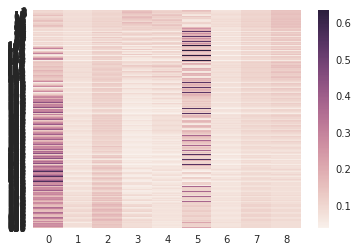

In [87]:
#sns.heatmap(np.concatenate(attn_dists, axis = 0))

In [22]:
# xticks:input_features
# yticks: 
y_date

Index([u'2015-03-10', u'2015-03-11', u'2015-03-12', u'2015-03-13',
       u'2015-03-16', u'2015-03-17', u'2015-03-18', u'2015-03-19',
       u'2015-03-20', u'2015-03-23',
       ...
       u'2017-09-25', u'2017-09-26', u'2017-09-27', u'2017-09-28',
       u'2017-09-29', u'2017-10-02', u'2017-10-03', u'2017-10-04',
       u'2017-10-05', u'2017-10-06'],
      dtype='object', name=u'Date', length=652)

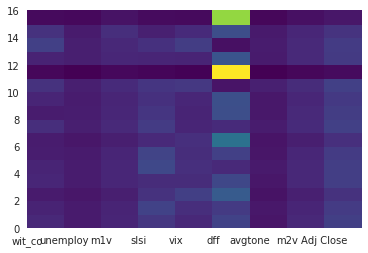

In [98]:
fig, ax = plt.subplots()
ax.set_xticks(range(INPUT_DIM))
ax.set_xticklabels(input_features, rotation='horizonta')
plt.pcolor(attn_dists[0],cmap=plt.cm.viridis)


In [110]:
attn_dists[0][0]

array([ 0.10430171,  0.08063494,  0.09986421,  0.13223076,  0.10430419,
        0.1552494 ,  0.07171996,  0.10293207,  0.14876279], dtype=float32)

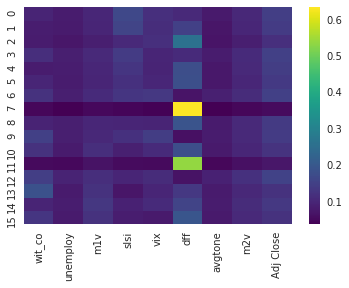

In [108]:
# heatmap
sns.heatmap(attn_dists[4], cmap = plt.cm.viridis, xticklabels = input_features)#, yticklabels = y_date[:batch_size])

In [18]:
# plot_num = 16

# for i in range(steps_test):
#     start_idx = i*plot_num
#     end_idx = (i+1)*plot_num
#     plt.figure()
#     plt.plot(range(plot_num),y_hat_arr[start_idx:end_idx])
#     plt.plot(range(plot_num),y_labels[start_idx:end_idx])
#     plt.draw()

In [62]:
# ## testing 

# steps_test = int(len(X_test)/batch_size)
# test_loss = 0.0
# y_hat_arr = np.empty(shape = [0])
# y_labels_arr = np.empty(shape = [0])
# batch = Batch(X_test,Y_test,batch_size = 16, seq_lens = 7, shuffle = False)
# new_model.is_train = False
# for t in range(steps_test):
    
#     x_test,y_test,labels_test = batch.get_batch(step = t)
#     labels_test = labels_test.reshape(-1)
#     y_hat = new_model.predict(x_test,y_test,sess) 
#     y_hat_arr = np.concatenate([y_hat_arr,np.array(y_hat)])
#     y_labels_arr = np.concatenate([y_labels_arr,np.array(labels_test)])
#     test_loss += np.mean(np.square(y_hat - labels_test))

# print "the mean squared error for test data are %f " % (test_loss*1.0/steps_test)

the mean squared error for test data are 40.940860 


In [126]:
batch_size = 16
INPUT_DIM = 9  # 9 input features
seq_lens = time_step = 7 # 7consecutive days to predict next day stock returns
n_hidden = 32 # encoder dim
d_hidden = 32 # decoder dim
total_epochs = 100
steps = int(len(X_train)/batch_size)

tf.reset_default_graph()
batch = Batch(X_train,Y_train,batch_size = batch_size, seq_lens = seq_lens, shuffle = False)
model_highway = ts_prediction(input_dim = INPUT_DIM, time_step = seq_lens, 
                      n_hidden= n_hidden, d_hidden = d_hidden, 
                      batch_size = batch_size, add_highway = True)
# model_highway.is_train = True
new_model_highway,sess = setup_training(model_highway, batch, steps, total_epochs = total_epochs)

steps_test = int(len(X_test)/batch_size)
batch_test = Batch(X_test,Y_test,batch_size = 16, seq_lens = 7, shuffle = False)
y_hat_arr, y_labels, attn_dists = setup_eval(new_model_highway, batch_test, steps_test, sess)



INFO:tensorflow:Preparing or waiting for sessions...
INFO:tensorflow:start run training...
INFO:tensorflow:Starting epoch 0
INFO:tensorflow:100 step loss sum: 0.016663
INFO:tensorflow:100 step loss sum: 0.026420
INFO:tensorflow:Starting epoch 1
INFO:tensorflow:100 step loss sum: 0.011500
INFO:tensorflow:100 step loss sum: 0.022546
INFO:tensorflow:Starting epoch 2
INFO:tensorflow:100 step loss sum: 0.013838
INFO:tensorflow:100 step loss sum: 0.020462
INFO:tensorflow:Starting epoch 3
INFO:tensorflow:100 step loss sum: 0.019599
INFO:tensorflow:100 step loss sum: 0.016539
INFO:tensorflow:100 step loss sum: 0.021649
INFO:tensorflow:Starting epoch 4
INFO:tensorflow:100 step loss sum: 0.011298
INFO:tensorflow:100 step loss sum: 0.024217
INFO:tensorflow:Starting epoch 5
INFO:tensorflow:100 step loss sum: 0.010365
INFO:tensorflow:100 step loss sum: 0.019551
INFO:tensorflow:Starting epoch 6
INFO:tensorflow:100 step loss sum: 0.018855
INFO:tensorflow:100 step loss sum: 0.018534
INFO:tensorflow:10

INFO:tensorflow:Starting epoch 60
INFO:tensorflow:100 step loss sum: 0.004273
INFO:tensorflow:100 step loss sum: 0.007623
INFO:tensorflow:Starting epoch 61
INFO:tensorflow:100 step loss sum: 0.005382
INFO:tensorflow:100 step loss sum: 0.006635
INFO:tensorflow:Starting epoch 62
INFO:tensorflow:100 step loss sum: 0.006071
INFO:tensorflow:100 step loss sum: 0.003918
INFO:tensorflow:Starting epoch 63
INFO:tensorflow:100 step loss sum: 0.008371
INFO:tensorflow:100 step loss sum: 0.003740
INFO:tensorflow:100 step loss sum: 0.008502
INFO:tensorflow:Starting epoch 64
INFO:tensorflow:100 step loss sum: 0.004726
INFO:tensorflow:100 step loss sum: 0.006690
INFO:tensorflow:Starting epoch 65
INFO:tensorflow:100 step loss sum: 0.005541
INFO:tensorflow:100 step loss sum: 0.004200
INFO:tensorflow:Starting epoch 66
INFO:tensorflow:100 step loss sum: 0.008312
INFO:tensorflow:100 step loss sum: 0.003653
INFO:tensorflow:100 step loss sum: 0.007981
INFO:tensorflow:Starting epoch 67
INFO:tensorflow:100 step

In [ ]:
plot_num = 16

for i in range(steps_test):
    start_idx = i*plot_num
    end_idx = (i+1)*plot_num
    plt.figure()
    plt.plot(range(plot_num),y_hat_arr[start_idx:end_idx])
    plt.plot(range(plot_num),y_labels[start_idx:end_idx])
    plt.draw()

In [1]:


# plot_num = 16

# for i in range(steps_test):
#     start_idx = i*plot_num
#     end_idx = (i+1)*plot_num
#     plt.figure()
#     plt.plot(range(plot_num),y_hat_arr[start_idx:end_idx])
#     plt.plot(range(plot_num),y_labels_arr[start_idx:end_idx])
#     plt.draw()
#     #plt.savefig('./adversarial_training1/range_%i.png' % i)

In [24]:
# no highway, d_hidden change to 64

batch_size = 16
INPUT_DIM = 8  # 8 input features
seq_lens = time_step = 7 # 7consecutive days to predict next day stock returns
n_hidden = 32 # encoder dim
d_hidden = 16 # decoder dim
total_epochs = 100
steps = int(len(X_train)/batch_size)

tf.reset_default_graph()
batch = Batch(X_train,Y_train,batch_size = batch_size, seq_lens = seq_lens, shuffle = False)
model = ts_prediction(input_dim = INPUT_DIM, time_step = seq_lens, n_hidden= n_hidden, d_hidden = d_hidden, batch_size = batch_size)
model.is_train = True
new_model,sess = setup_training(model, batch, steps, total_epochs = total_epochs)

steps_test = int(len(X_test)/batch_size)
batch_test = Batch(X_test,Y_test,batch_size = 16, seq_lens = 7, shuffle = False)
y_hat_arr, y_labels, attn_dists = setup_eval(new_model, batch_test, steps_test, sess)


INFO:tensorflow:Preparing or waiting for sessions...
INFO:tensorflow:start run training...
INFO:tensorflow:Starting epoch 0
INFO:tensorflow:100 step loss sum: 0.073493
INFO:tensorflow:100 step loss sum: 0.099542
INFO:tensorflow:Starting epoch 1
INFO:tensorflow:100 step loss sum: 0.036530
INFO:tensorflow:100 step loss sum: 0.042865
INFO:tensorflow:Starting epoch 2
INFO:tensorflow:100 step loss sum: 0.024871
INFO:tensorflow:100 step loss sum: 0.032346
INFO:tensorflow:Starting epoch 3
INFO:tensorflow:100 step loss sum: 0.027279
INFO:tensorflow:100 step loss sum: 0.022947
INFO:tensorflow:100 step loss sum: 0.026331
INFO:tensorflow:Starting epoch 4
INFO:tensorflow:100 step loss sum: 0.015668
INFO:tensorflow:100 step loss sum: 0.028797
INFO:tensorflow:Starting epoch 5
INFO:tensorflow:100 step loss sum: 0.013639
INFO:tensorflow:100 step loss sum: 0.023645
INFO:tensorflow:Starting epoch 6
INFO:tensorflow:100 step loss sum: 0.021552
INFO:tensorflow:100 step loss sum: 0.021992
INFO:tensorflow:10

INFO:tensorflow:Starting epoch 60
INFO:tensorflow:100 step loss sum: 0.009938
INFO:tensorflow:100 step loss sum: 0.016803
INFO:tensorflow:Starting epoch 61
INFO:tensorflow:100 step loss sum: 0.008005
INFO:tensorflow:100 step loss sum: 0.015741
INFO:tensorflow:Starting epoch 62
INFO:tensorflow:100 step loss sum: 0.011534
INFO:tensorflow:100 step loss sum: 0.012008
INFO:tensorflow:Starting epoch 63
INFO:tensorflow:100 step loss sum: 0.015753
INFO:tensorflow:100 step loss sum: 0.010440
INFO:tensorflow:100 step loss sum: 0.015841
INFO:tensorflow:Starting epoch 64
INFO:tensorflow:100 step loss sum: 0.008253
INFO:tensorflow:100 step loss sum: 0.017038
INFO:tensorflow:Starting epoch 65
INFO:tensorflow:100 step loss sum: 0.008947
INFO:tensorflow:100 step loss sum: 0.012405
INFO:tensorflow:Starting epoch 66
INFO:tensorflow:100 step loss sum: 0.014795
INFO:tensorflow:100 step loss sum: 0.011248
INFO:tensorflow:100 step loss sum: 0.015059
INFO:tensorflow:Starting epoch 67
INFO:tensorflow:100 step

In [ ]:
# no highway, n_hidden change to 64

batch_size = 16
INPUT_DIM = 8  # 8 input features
seq_lens = time_step = 7 # 7consecutive days to predict next day stock returns
n_hidden = 64 # encoder dim
d_hidden = 32 # decoder dim
total_epochs = 150
steps = int(len(X_train)/batch_size)

tf.reset_default_graph()
batch = Batch(X_train,Y_train,batch_size = batch_size, seq_lens = seq_lens, shuffle = False)
model = ts_prediction(input_dim = INPUT_DIM, time_step = seq_lens, n_hidden= n_hidden, d_hidden = d_hidden, batch_size = batch_size)
model.is_train = True
new_model,sess = setup_training(model, batch, steps, total_epochs = total_epochs)

steps_test = int(len(X_test)/batch_size)
batch_test = Batch(X_test,Y_test,batch_size = 16, seq_lens = 7, shuffle = False)
y_hat_arr, y_labels, attn_dists = setup_eval(new_model, batch_test, steps_test, sess)



INFO:tensorflow:Preparing or waiting for sessions...
INFO:tensorflow:start run training...
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Starting epoch 0
INFO:tensorflow:100 step loss sum: 3877.828106
INFO:tensorflow:100 step loss sum: 22936.802439
INFO:tensorflow:Starting epoch 1
INFO:tensorflow:100 step loss sum: 13978.696056
INFO:tensorflow:100 step loss sum: 21068.775036
INFO:tensorflow:100 step loss sum: 14306.364748
INFO:tensorflow:Starting epoch 2
INFO:tensorflow:100 step loss sum: 11826.781054
INFO:tensorflow:100 step loss sum: 18707.645027
INFO:tensorflow:Starting epoch 3
INFO:tensorflow:100 step loss sum: 9620.142187
INFO:tensorflow:100 step loss sum: 17825.189442
INFO:tensorflow:Starting epoch 4
INFO:tensorflow:100 step loss sum: 12903.366650
INFO:tensorflow:100 step loss sum: 17934.800901
INFO:tensorflow:100 step loss sum: 12945.998688
INFO:tensorflow:Starting epoch 5
INFO:tensorflow:100 step loss sum: 13170.026535
INFO:tensorflow:100 step loss sum: 17438.057619
INFO:t

INFO:tensorflow:Starting epoch 55
INFO:tensorflow:100 step loss sum: 4006.470812
INFO:tensorflow:100 step loss sum: 5927.070658
INFO:tensorflow:Starting epoch 56
INFO:tensorflow:100 step loss sum: 5218.062096
INFO:tensorflow:100 step loss sum: 6955.708714
INFO:tensorflow:Starting epoch 57
INFO:tensorflow:100 step loss sum: 5669.661205
INFO:tensorflow:100 step loss sum: 5170.521864
INFO:tensorflow:Starting epoch 58
INFO:tensorflow:100 step loss sum: 6085.520211
INFO:tensorflow:100 step loss sum: 4722.295362
INFO:tensorflow:100 step loss sum: 4914.670549
INFO:tensorflow:Starting epoch 59
INFO:tensorflow:100 step loss sum: 3725.149484
INFO:tensorflow:100 step loss sum: 5569.566324
INFO:tensorflow:Starting epoch 60
INFO:tensorflow:100 step loss sum: 4586.039342
INFO:tensorflow:100 step loss sum: 4889.042669
INFO:tensorflow:Starting epoch 61
INFO:tensorflow:100 step loss sum: 5517.630835
INFO:tensorflow:100 step loss sum: 4805.891299
INFO:tensorflow:100 step loss sum: 5143.044834
INFO:tenso

INFO:tensorflow:100 step loss sum: 4242.763857
INFO:tensorflow:Starting epoch 113
INFO:tensorflow:100 step loss sum: 3683.669335
INFO:tensorflow:100 step loss sum: 3933.356582
INFO:tensorflow:Starting epoch 114
INFO:tensorflow:100 step loss sum: 4531.481862
INFO:tensorflow:100 step loss sum: 3695.159380
INFO:tensorflow:100 step loss sum: 4140.674933
INFO:tensorflow:Starting epoch 115
INFO:tensorflow:100 step loss sum: 2765.364353
INFO:tensorflow:100 step loss sum: 4257.694683
INFO:tensorflow:Starting epoch 116
INFO:tensorflow:100 step loss sum: 3018.321903
INFO:tensorflow:100 step loss sum: 3851.487502
INFO:tensorflow:Starting epoch 117
INFO:tensorflow:100 step loss sum: 4065.177315
INFO:tensorflow:100 step loss sum: 3611.539048
INFO:tensorflow:Starting epoch 118
INFO:tensorflow:100 step loss sum: 4425.143617
INFO:tensorflow:100 step loss sum: 3577.457643
INFO:tensorflow:100 step loss sum: 4018.871265
INFO:tensorflow:Starting epoch 119
INFO:tensorflow:100 step loss sum: 2721.598207
INF

In [ ]:
plot_num = 16

for i in range(steps_test):
    start_idx = i*plot_num
    end_idx = (i+1)*plot_num
    plt.figure()
    plt.plot(range(plot_num),y_hat_arr[start_idx:end_idx])
    plt.plot(range(plot_num),y_labels[start_idx:end_idx])
    plt.draw()

In [81]:
batch_size = 16
INPUT_DIM = 9  # 12 input features
seq_lens = time_step = 7 # 7 consecutive days to predict next day stock returns
n_hidden = 32 # encoder dim
d_hidden = 32 # decoder dim
# train_dir = './ts_traindir'
## o_hidden = 16 default

current_episode = 0
total_episodes = 40

steps = int(len(X_train)/batch_size)

tf.reset_default_graph()
model = ts_prediction(input_dim = INPUT_DIM, time_step = seq_lens, n_hidden= n_hidden, d_hidden = d_hidden, batch_size = batch_size)
model.is_train = True
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


batch = Batch(X_train,Y_train,batch_size = batch_size, seq_lens = seq_lens, shuffle = False)
t = 0 
x,y,labels = batch.get_batch(step = t)
train_seq_len =  np.ones(batch_size) * seq_lens
feed = {model.input_x: x, 
        model.seq_len: train_seq_len,
        model.input_y: y,
        model.label: labels}
tf.logging.info('Running train step...') ##
results = model.run_train_step(sess,feed)
tf.logging.info('loss: %f', results['loss'])
#loss_1, adversarial_gradients = sess.run([model.loss_1,model.adversarial_gradient],feed_dict = feed)
#loss = sess.run([model.loss],feed_dict = feed)

INFO:tensorflow:Running train step...
INFO:tensorflow:loss: 196.961731


In [15]:
# no highway, n_hidden change to 64

batch_size = 16
INPUT_DIM = 8  # 8 input features
seq_lens = time_step = 7 # 7consecutive days to predict next day stock returns
n_hidden = 64 # encoder dim
d_hidden = 32 # decoder dim
total_epochs = 200
steps = int(len(X_train)/batch_size)

tf.reset_default_graph()
batch = Batch(X_train,Y_train,batch_size = batch_size, seq_lens = seq_lens, shuffle = False)
model = ts_prediction(input_dim = INPUT_DIM, time_step = seq_lens, n_hidden= n_hidden, d_hidden = d_hidden, batch_size = batch_size)
model.is_train = True
new_model,sess = setup_training(model, batch, steps, total_epochs = total_epochs)

steps_test = int(len(X_test)/batch_size)
batch_test = Batch(X_test,Y_test,batch_size = 16, seq_lens = 7, shuffle = False)
y_hat_arr, y_labels, attn_dists = setup_eval(new_model, batch_test, steps_test, sess)




INFO:tensorflow:Preparing or waiting for sessions...
INFO:tensorflow:start run training...
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Starting epoch 0
INFO:tensorflow:100 step loss sum: 23711.335693
INFO:tensorflow:100 step loss sum: 32180.171761
INFO:tensorflow:Starting epoch 1
INFO:tensorflow:100 step loss sum: 17644.165493
INFO:tensorflow:100 step loss sum: 30132.875988
INFO:tensorflow:Starting epoch 2
INFO:tensorflow:100 step loss sum: 18188.837547
INFO:tensorflow:100 step loss sum: 27609.669773
INFO:tensorflow:Starting epoch 3
INFO:tensorflow:100 step loss sum: 25095.190926
INFO:tensorflow:100 step loss sum: 23016.299576
INFO:tensorflow:100 step loss sum: 26479.380497
INFO:tensorflow:Starting epoch 4
INFO:tensorflow:100 step loss sum: 16512.558735
INFO:tensorflow:100 step loss sum: 29173.456787
INFO:tensorflow:Starting epoch 5
INFO:tensorflow:100 step loss sum: 13594.378040
INFO:tensorflow:100 step loss sum: 24982.069227
INFO:tensorflow:Starting epoch 6
INFO:tensorflow:100

INFO:tensorflow:Starting epoch 56
INFO:tensorflow:100 step loss sum: 15135.570261
INFO:tensorflow:100 step loss sum: 11247.257988
INFO:tensorflow:100 step loss sum: 15235.855651
INFO:tensorflow:Starting epoch 57
INFO:tensorflow:100 step loss sum: 8191.021923
INFO:tensorflow:100 step loss sum: 16500.554565
INFO:tensorflow:Starting epoch 58
INFO:tensorflow:100 step loss sum: 8513.830496
INFO:tensorflow:100 step loss sum: 12817.192122
INFO:tensorflow:Starting epoch 59
INFO:tensorflow:100 step loss sum: 12839.656702
INFO:tensorflow:100 step loss sum: 10687.361228
INFO:tensorflow:100 step loss sum: 14931.377991
INFO:tensorflow:Starting epoch 60
INFO:tensorflow:100 step loss sum: 8272.005900
INFO:tensorflow:100 step loss sum: 15564.502209
INFO:tensorflow:Starting epoch 61
INFO:tensorflow:100 step loss sum: 8695.890591
INFO:tensorflow:100 step loss sum: 13895.149292
INFO:tensorflow:Starting epoch 62
INFO:tensorflow:100 step loss sum: 10547.861397
INFO:tensorflow:100 step loss sum: 9954.481167

INFO:tensorflow:100 step loss sum: 9067.275694
INFO:tensorflow:100 step loss sum: 7324.340144
INFO:tensorflow:Starting epoch 113
INFO:tensorflow:100 step loss sum: 12738.899418
INFO:tensorflow:100 step loss sum: 6536.222961
INFO:tensorflow:100 step loss sum: 12261.590782
INFO:tensorflow:Starting epoch 114
INFO:tensorflow:100 step loss sum: 6628.578022
INFO:tensorflow:100 step loss sum: 11812.553671
INFO:tensorflow:Starting epoch 115
INFO:tensorflow:100 step loss sum: 7574.055819
INFO:tensorflow:100 step loss sum: 7977.127964
INFO:tensorflow:Starting epoch 116
INFO:tensorflow:100 step loss sum: 12142.248465
INFO:tensorflow:100 step loss sum: 7466.561392
INFO:tensorflow:100 step loss sum: 11746.441565
INFO:tensorflow:Starting epoch 117
INFO:tensorflow:100 step loss sum: 6051.781809
INFO:tensorflow:100 step loss sum: 12545.625129
INFO:tensorflow:Starting epoch 118
INFO:tensorflow:100 step loss sum: 7083.631907
INFO:tensorflow:100 step loss sum: 9763.186649
INFO:tensorflow:Starting epoch 1

INFO:tensorflow:100 step loss sum: 6584.961848
INFO:tensorflow:100 step loss sum: 8169.025411
INFO:tensorflow:Starting epoch 169
INFO:tensorflow:100 step loss sum: 9948.706467
INFO:tensorflow:100 step loss sum: 5772.186467
INFO:tensorflow:100 step loss sum: 11793.252476
INFO:tensorflow:Starting epoch 170
INFO:tensorflow:100 step loss sum: 5154.989268
INFO:tensorflow:100 step loss sum: 10397.173975
INFO:tensorflow:Starting epoch 171
INFO:tensorflow:100 step loss sum: 6642.760017
INFO:tensorflow:100 step loss sum: 9744.015356
INFO:tensorflow:Starting epoch 172
INFO:tensorflow:100 step loss sum: 8318.350883
INFO:tensorflow:100 step loss sum: 5461.240166
INFO:tensorflow:Starting epoch 173
INFO:tensorflow:100 step loss sum: 11888.326263
INFO:tensorflow:100 step loss sum: 5589.537082
INFO:tensorflow:100 step loss sum: 10989.150869
INFO:tensorflow:Starting epoch 174
INFO:tensorflow:100 step loss sum: 5937.992623
INFO:tensorflow:100 step loss sum: 10341.679661
INFO:tensorflow:Starting epoch 17

/usr/lib64/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib64/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


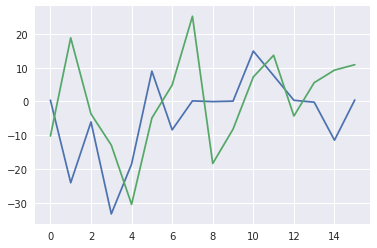

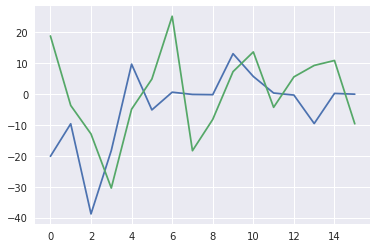

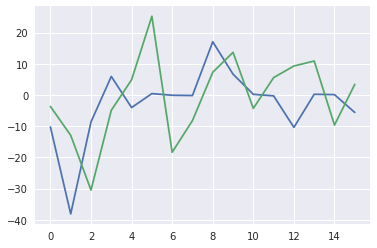

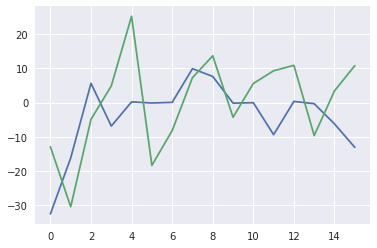

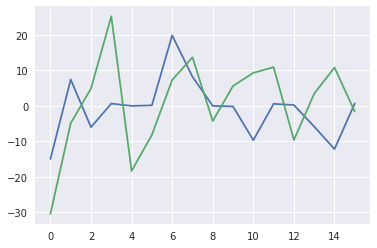

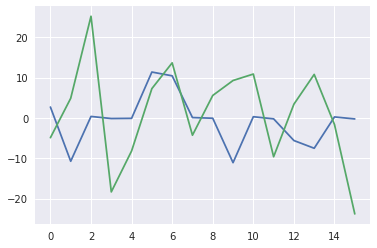

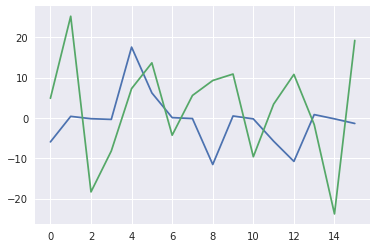

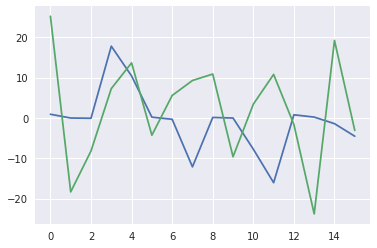

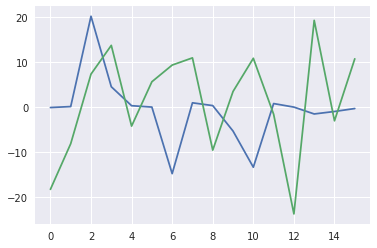

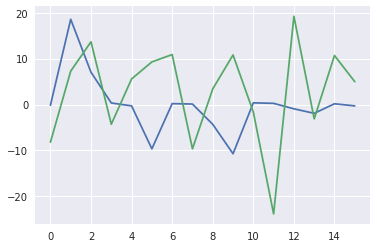

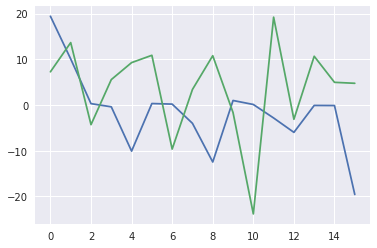

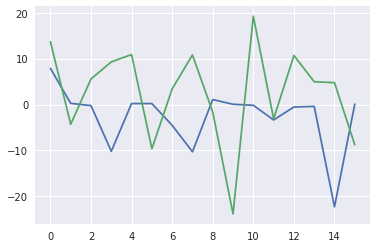

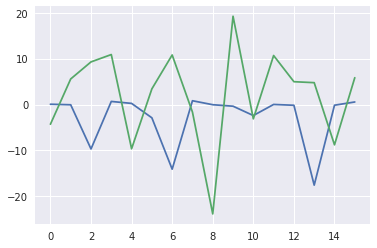

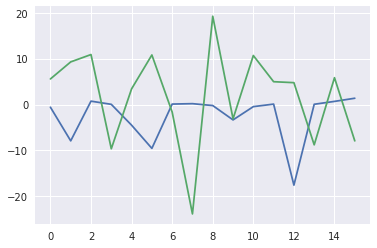

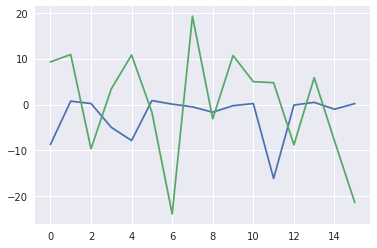

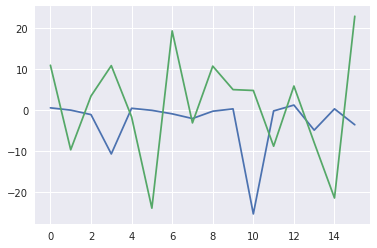

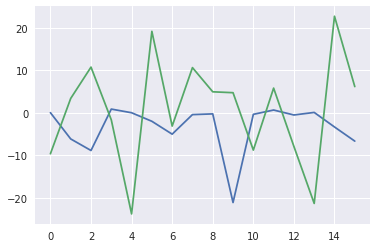

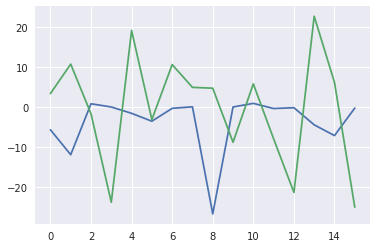

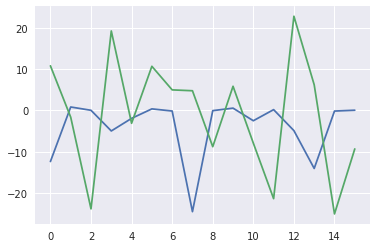

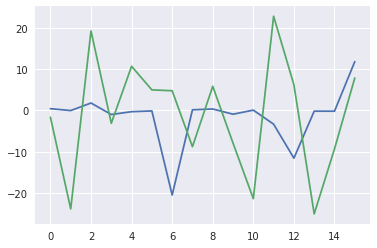

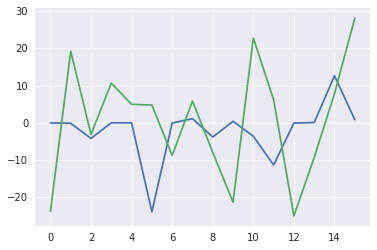

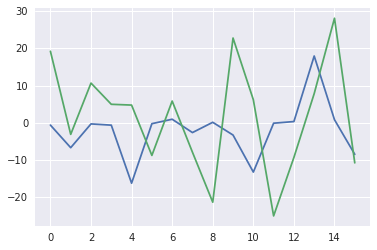

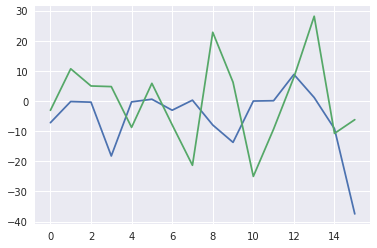

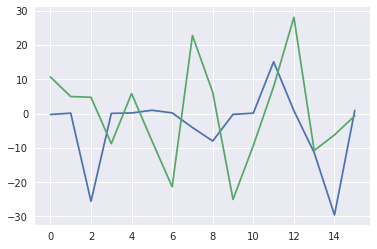

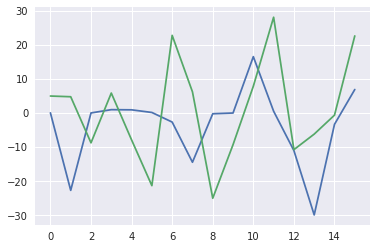

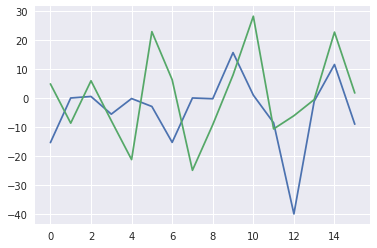

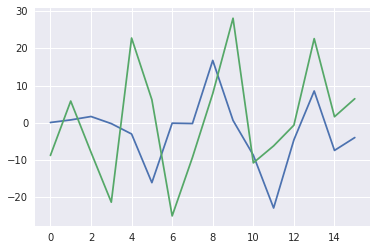

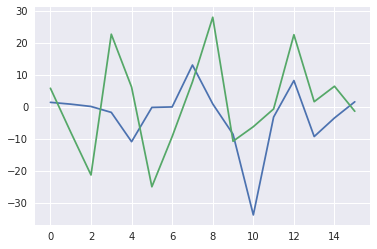

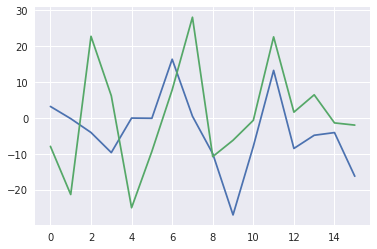

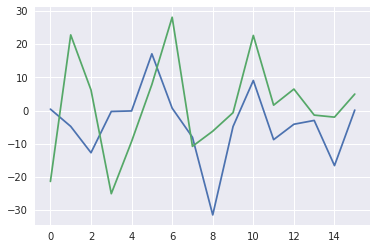

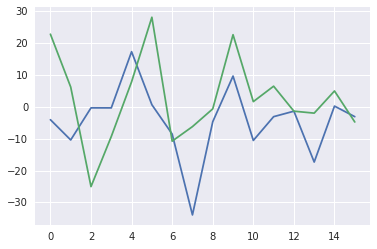

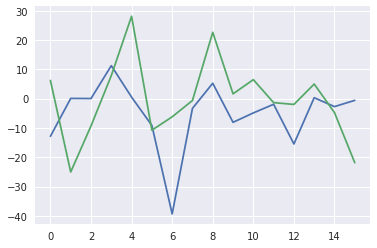

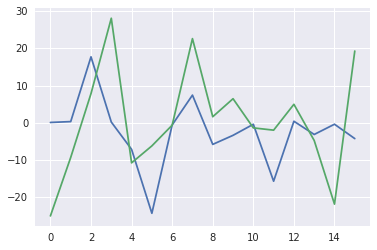

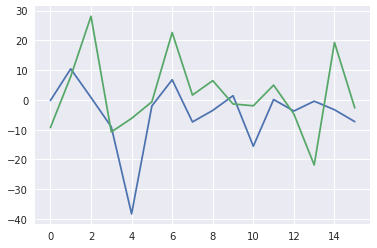

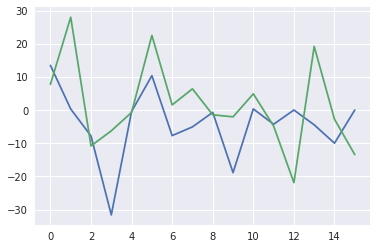

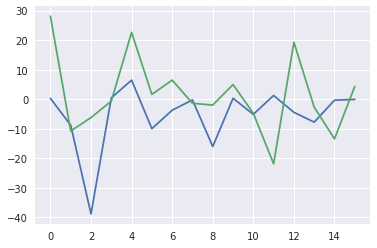

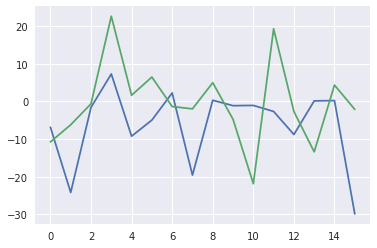

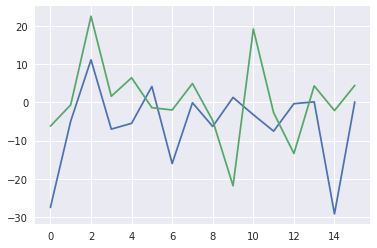

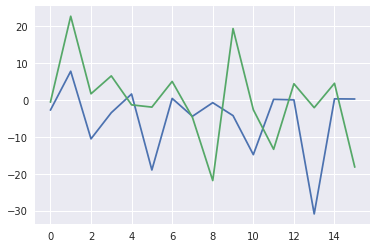

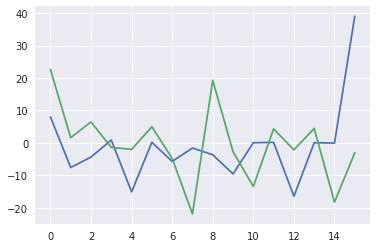

In [16]:
plot_num = 16

for i in range(steps_test):
    start_idx = i*plot_num
    end_idx = (i+1)*plot_num
    plt.figure()
    plt.plot(range(plot_num),y_hat_arr[start_idx:end_idx])
    plt.plot(range(plot_num),y_labels[start_idx:end_idx])
    plt.draw()

/usr/lib64/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib64/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


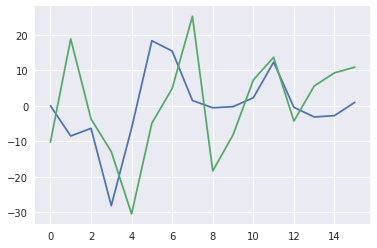

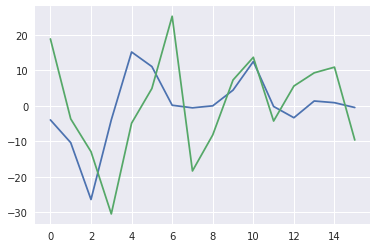

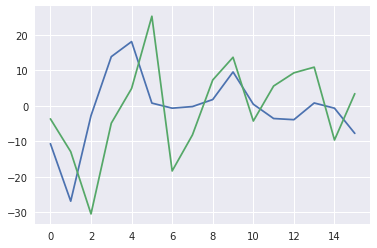

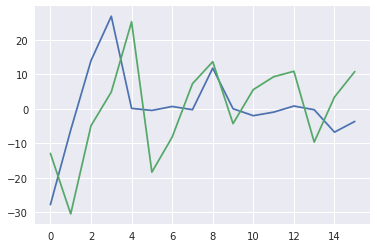

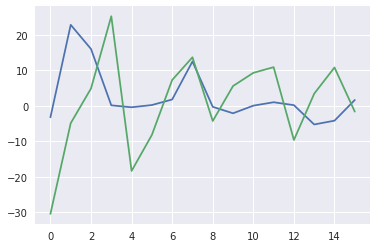

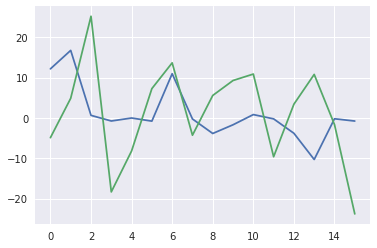

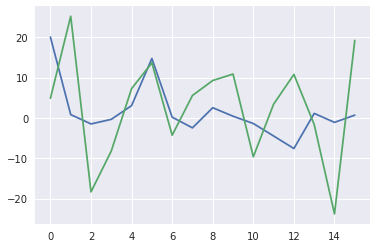

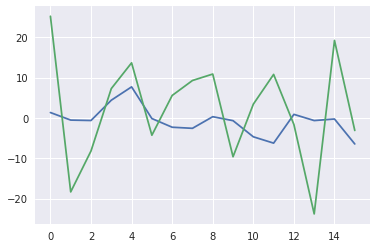

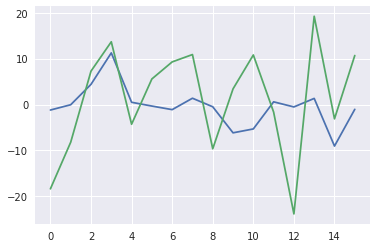

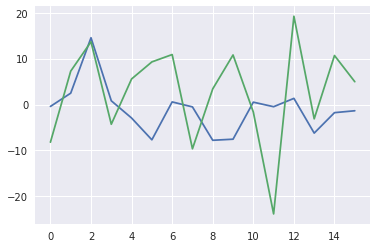

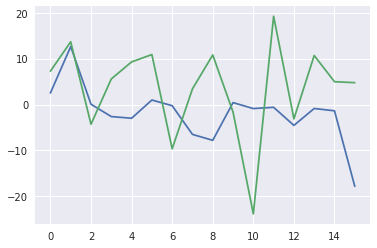

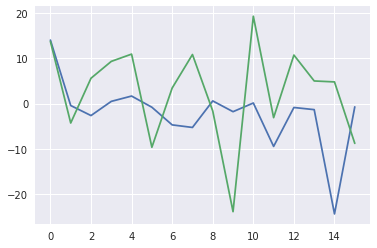

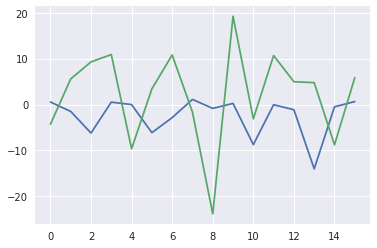

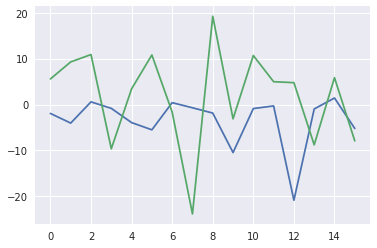

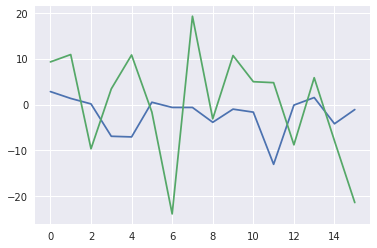

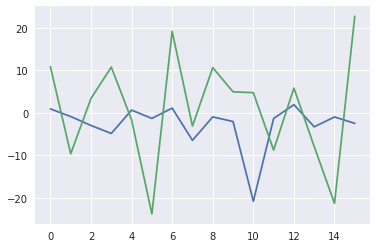

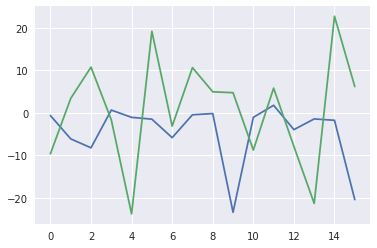

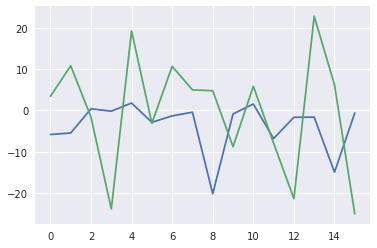

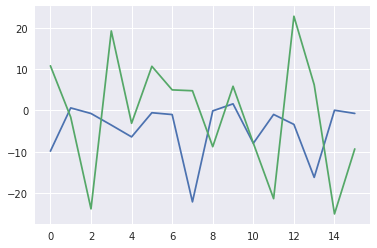

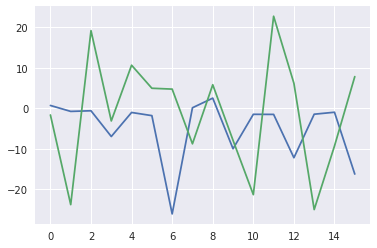

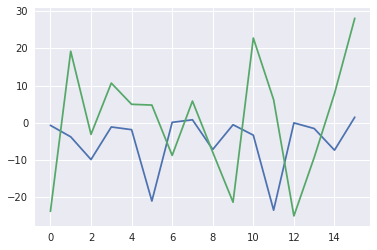

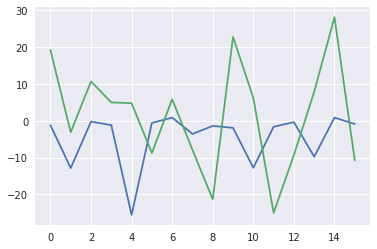

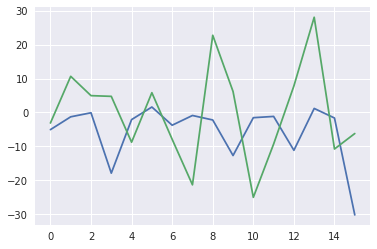

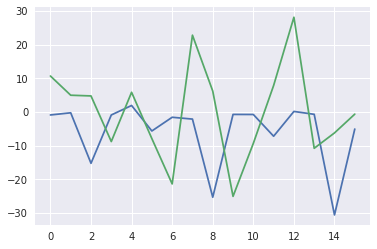

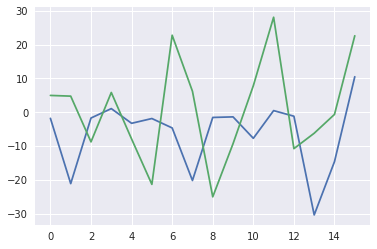

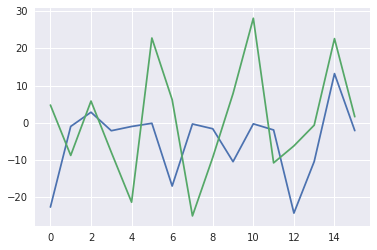

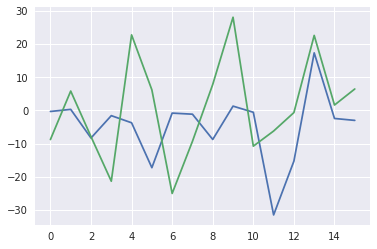

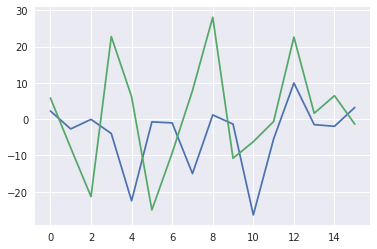

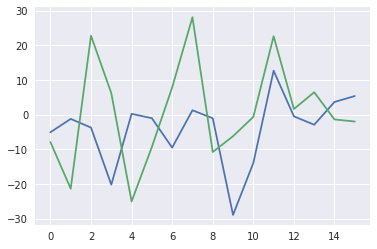

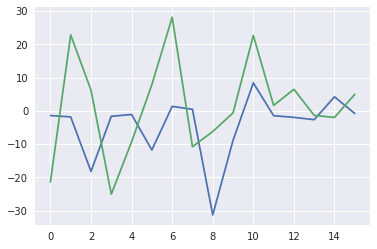

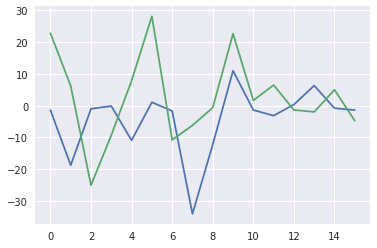

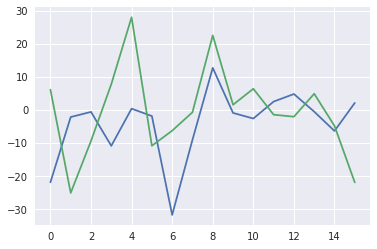

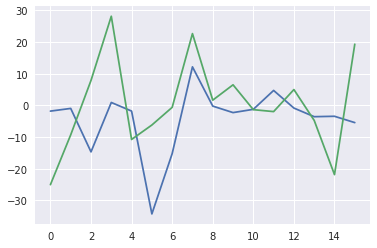

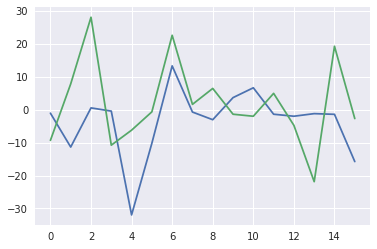

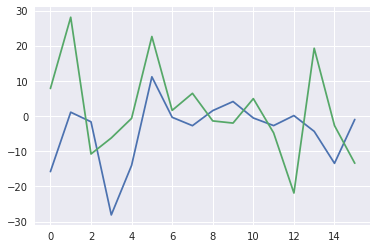

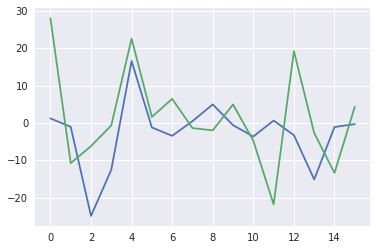

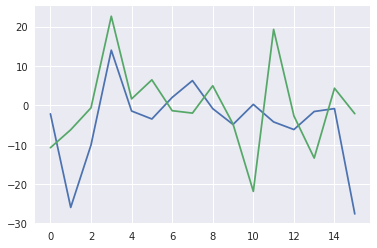

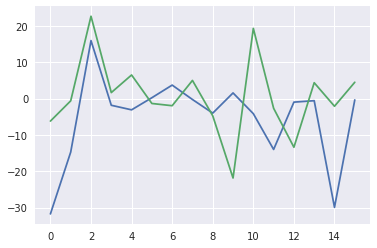

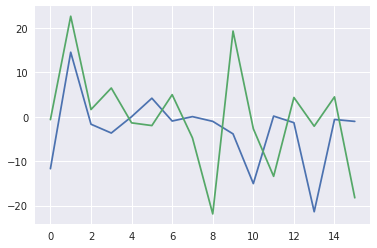

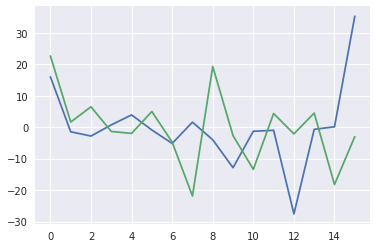

In [19]:
# the 10:00 am one
plot_num = 16

for i in range(steps_test):
    start_idx = i*plot_num
    end_idx = (i+1)*plot_num
    plt.figure()
    plt.plot(range(plot_num),y_hat_arr[start_idx:end_idx])
    plt.plot(range(plot_num),y_labels[start_idx:end_idx])
    plt.draw()
    plt.savefig('./17capstone/range_%i.png' % i)

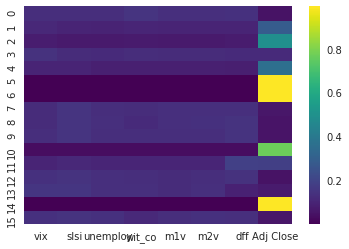

In [31]:
sns.heatmap(attn_dists[0], cmap = plt.cm.viridis, xticklabels = input_features)#, yticklabels = y_date[:batch_size])
plt.savefig('./17capstone/heat_%i.png' % 1)

In [45]:
# # no highway, n_hidden change to 64

# batch_size = 16
# INPUT_DIM = 7  # 8 input features
# seq_lens = time_step = 7 # 7consecutive days to predict next day stock returns
# n_hidden = 32 # encoder dim
# d_hidden = 32 # decoder dim
# total_epochs = 200
# steps = int(len(X_train)/batch_size)

# tf.reset_default_graph()
# batch = Batch(X_train,Y_train,batch_size = batch_size, seq_lens = seq_lens, shuffle = False)
# model = ts_prediction(input_dim = INPUT_DIM, time_step = seq_lens, n_hidden= n_hidden, d_hidden = d_hidden, batch_size = batch_size, add_highway = True)
# model.is_train = True
# new_model,sess = setup_training(model, batch, steps, total_epochs = total_epochs)

# steps_test = int(len(X_test)/batch_size)
# batch_test = Batch(X_test,Y_test,batch_size = 16, seq_lens = 7, shuffle = False)
# y_hat_arr, y_labels, attn_dists = setup_eval(new_model, batch_test, steps_test, sess)


/usr/lib64/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


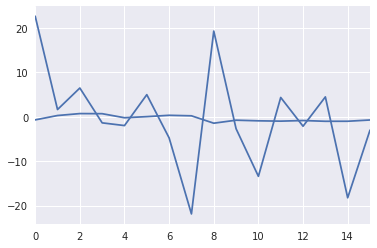

In [27]:
batch_size = 16
INPUT_DIM = 9  # 12 input features
seq_lens = time_step = 7 # 7 consecutive days to predict next day stock returns
n_hidden = 32 # encoder dim
d_hidden = 32 # decoder dim
# train_dir = './ts_traindir'
## o_hidden = 16 default

current_episode = 0
total_episodes = 40

steps = int(len(X_train)/batch_size)

tf.reset_default_graph()
model = ts_prediction(input_dim = INPUT_DIM, time_step = seq_lens, n_hidden= n_hidden, d_hidden = d_hidden, batch_size = batch_size)
model.is_train = True
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch = Batch(X_train,Y_train,batch_size = batch_size, seq_lens = seq_lens, shuffle = False)
t = 0 
x,y,labels = batch.get_batch(step = t)
train_seq_len =  np.ones(batch_size) * seq_lens
feed = {model.input_x: x, 
        model.seq_len: train_seq_len,
        model.input_y: y,
        model.label: labels}
#loss_1, adversarial_gradients = sess.run([model.loss_1,model.adversarial_gradient],feed_dict = feed)
loss = sess.run([model.loss],feed_dict = feed)

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

plot_num = 16

for i in range(steps_test):
    start_idx = i*plot_num
    end_idx = (i+1)*plot_num
    plt.figure()
    plt.plot(range(plot_num),y_hat_arr[start_idx:end_idx])
    plt.plot(range(plot_num),y_labels_arr[start_idx:end_idx])
    plt.draw()
    #plt.savefig('./adversarial_training1/range_%i.png' % i)

In [ ]:
def calc_running_avg_loss(loss, running_avg_loss, summary_writer, step, decay=0.99):
    """Calculate the running average loss via exponential decay.
        This is used to implement early stopping w.r.t. a more smooth loss curve than the raw loss curve.
    Args:
        loss: loss on the most recent eval step
        running_avg_loss: running_avg_loss so far
        summary_writer: FileWriter object to write for tensorboard
        step: training iteration step
        decay: rate of exponential decay, a float between 0 and 1. Larger is smoother.
    Returns:
        running_avg_loss: new running average loss
    """
    if running_avg_loss == 0:  # on the first iteration just take the loss
        running_avg_loss = loss
    else:
        running_avg_loss = running_avg_loss * decay + (1 - decay) * loss
    running_avg_loss = min(running_avg_loss, 12)  # clip
    loss_sum = tf.Summary()
    tag_name = 'running_avg_loss/decay=%f' % (decay)
    loss_sum.value.add(tag=tag_name, simple_value=running_avg_loss)
    summary_writer.add_summary(loss_sum, step)
    
    return running_avg_loss
